In [1]:
pip install tensorflow librosa scikit-learn matplotlib numpy


In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [16]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, TimeDistributed
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt



In [17]:
# Set the path to the RAVDESS dataset
DATA_PATH = "/content/gdrive/MyDrive/RAVDESS Emotional speech audio"



In [18]:
# Function to extract MFCC features from audio files
def extract_features(file_path, max_pad_len=174):
    audio, sample_rate = librosa.load(file_path, sr=22050)
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    pad_width = max_pad_len - mfcc.shape[1]
    if pad_width > 0:
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc



In [19]:
# Load dataset and extract features
def load_data(data_path):
    X, y = [], []
    for root, _, files in os.walk(data_path):
        for file in files:
            if file.endswith(".wav"):
                emotion = int(file.split("-")[2]) - 1  # Extract emotion label from filename
                feature = extract_features(os.path.join(root, file))
                X.append(feature)
                y.append(emotion)
    return np.array(X), np.array(y)

# Load the data
X, y = load_data(DATA_PATH)



In [20]:
# Encode labels and split the data
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y = to_categorical(y)

X = X[..., np.newaxis]  # Add channel dimension



In [21]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN-BiLSTM model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(40, 174, 1)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # BiLSTM layer for capturing temporal dependencies
    tf.keras.layers.Reshape((1, 128)),
    Bidirectional(LSTM(64)),

    Dense(y_train.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')



Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 393ms/step - accuracy: 0.1437 - loss: 2.1101 - val_accuracy: 0.2448 - val_loss: 1.9649
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 346ms/step - accuracy: 0.2259 - loss: 1.9989 - val_accuracy: 0.2326 - val_loss: 1.8638
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 373ms/step - accuracy: 0.2419 - loss: 1.9506 - val_accuracy: 0.3229 - val_loss: 1.7903
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 373ms/step - accuracy: 0.2770 - loss: 1.8542 - val_accuracy: 0.3108 - val_loss: 1.7971
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 365ms/step - accuracy: 0.2833 - loss: 1.8492 - val_accuracy: 0.3351 - val_loss: 1.7351
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 348ms/step - accuracy: 0.3353 - loss: 1.7759 - val_accuracy: 0.3420 - val_loss: 1.6722
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.3211 - loss: 1.7599 - val_accuracy: 0.3438 - val_loss: 1.7114
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 376ms/step - accuracy: 0.3610 - loss: 1.7072 - val_accu

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93        43
           1       0.97      1.00      0.99        66
           2       0.95      0.97      0.96        71
           3       0.96      0.90      0.93        86
           4       0.97      0.95      0.96        81
           5       0.93      0.93      0.93        72
           6       0.97      0.97      0.97        71
           7       1.00      0.98      0.99        86

    accuracy                           0.96       576
   macro avg       0.95      0.96      0.96       576
weighted avg       0.96      0.96      0.96       576

Confusion Matrix:
 [[43  0  0  0  0  0  0  0]
 [ 0 66  0  0  0  0  0  0]
 [ 0  0 69  0  0  2  0  0]
 [ 4  2  0 77  0  3  0  0]
 [ 0  0  2  0 77  0  2  0]
 [ 2  0  0  3  0 67  0  0]
 [ 0  0  0  0  2  0 69  0]
 [ 0  0  2  0  0  0  0 84]]


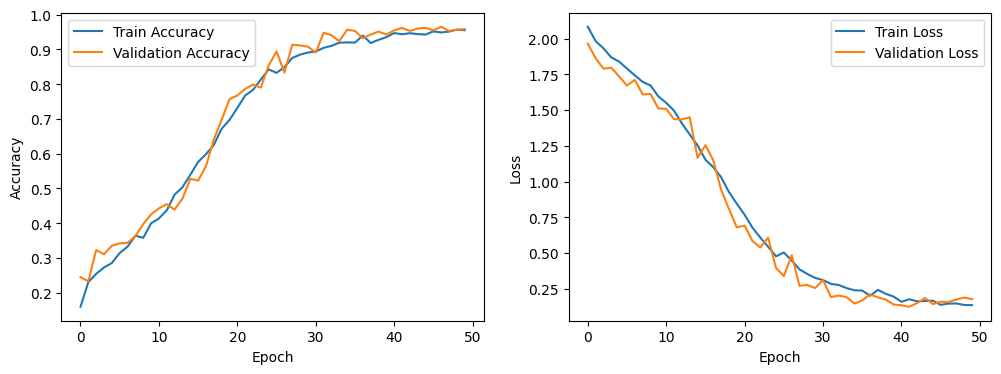

In [23]:
# Generate classification report and confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred_classes))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)
